# Lab 5: Iteration 2

Group Members:

- Parker Brown

- Suma Chackola

- Chris Peters

- Oliver Raney



Motivate the need for the research project. 
- Why is this investigation important? 
- What related work are you building from? 
- What are the main research question(s)? 
- What is your hypothesis for what will happen? 
- Try to make this the first draft of the introduction and related work for the final paper. 

You have a great deal of free rein to decide what analyses you should use and therefore you will be graded on the appropriateness of the methods chosen.  Argue for a few analyses that can help to answer your research question. You should argue for more than one kind of analysis to help answer your research questions. Try to make this the first draft of the methods section for a final paper.

Perform one part of the analysis to help answer one (or more) research question(s). 
- Create visualizations that will help to provide evidence. 
- Discuss the results and how they provide evidence for answering the research questions. 
- Try to make this a first draft of one section of the results in your final paper. 
- Try to have at least one visualization that you plan to use as a figure in the final paper. 

___________________________________

# Emitter Localization using Q-Learning Optimized Sensor Positioning
By:  Parker Brown, Suma Chackola, Chris Peters, Oliver Raney

## Iteration 2:


*Iteration 2*

The second iteration shifts focus to $N$-directional movements informed by the LOCA algorithm, where drones move towards the estimated position of the emitter. The estimated position is found by an average of the LOCA output, called the centroid, where subsets of sensors provide individual estimates with LOCA and the target's position is approximated by averaging these estimates. We determine the direction of movement using the current position of the sensor and the estimated target position. This iteration still employs the reward mechanism based on increased RSS but integrates more precise directional guidance from LOCA data. 


*Success Metric*

The success of each iteration is measured by the decreasing radius of the error ellipse and the reduction in the Euclidean distance between the center of this ellipse and the true target position. The system iterates until it reaches a predefined number of steps, a time limit, or the emitter is within a specified radius, indicating successful localization. We keep this metric the same across all iterations in order to maintain a fair comparison of success.

Additionally, the system's robustness and accuracy will be tested through Monte Carlo simulations with a series of initial positions to validate the localization estimates against the true target location. Each iteration will be conducted in 2 dimensional environments, where mostly zero-mean Gaussian-distributed error is added to the TOA, $\epsilon_t$ with $\sigma^2 = 10 ns$, to the individual sensor positions, with $\epsilon_x, \epsilon_y, \epsilon_z$ having $\sigma^2 = 2 cm$, including additional time delay due to multipath, with $\epsilon_n$ as $\sigma^2 = 10 ns$, and including a corresponding RSS noise value for multipath & signal fading, $\epsilon_p$ as $\mu = 3 dB$ and $\sigma^2 = 5 dB$. 

___________________________________

In [24]:
#!pip install gym

In [25]:
# Import Necessary Functions
import numpy as np
import matplotlib.pyplot as plt
from pettingzoo import AECEnv
from gym.spaces import Discrete, Box
from itertools import combinations

In [26]:
# LOCA Algorithm (Ralph Schmidt, 1972, https://ieeexplore.ieee.org/document/4103057) is below
# This LOCA Function enumerates all solutions - assuming at least 4 sensors for 2D

def LOCAfun_allcombs_2D(P1, S1):
    i_soln = 0
    xyWLS_comb = []
    for pqty in range(4, P1.shape[0] + 1):  # Count number of sensors
        for pmax in range(4, P1.shape[0] + 1):  # Count number of sensors
            prange = np.arange(1, pmax + 1)  # Use entire range of sensors for nchoosek calc
            combels = np.array(list(combinations(prange, pqty)))  # All combs with pqty sensors
            for combqty in range(combels.shape[0]):  # Number of rows in combinations 
                els = combels.shape[1]
                P = np.zeros((els, 2))
                P[0:els, :] = P1[combels[combqty, 0:els] - 1, :]
                S = S1[combels[combqty, 0:els] - 1]

                N = P.shape[0]
                combs = np.math.comb(N, 3)  # N-choose-3

                cl = 3e8
                xis, yis = P[:, 0], P[:, 1]
                sumdijk = np.zeros(combs)
                Am = np.zeros(combs)
                Bm = np.zeros(combs)
                Dm = np.zeros(combs)
                mc = np.zeros((combs, 3))
                ai = np.zeros(N)
                dijk = np.zeros((N, N))

                for i in range(N):
                    ai[i] = np.sqrt(xis[i]**2 + yis[i]**2)
                    for j in range(N):
                        dijk[i, j] = cl * (S[j] - S[i])

                m = 0
                for i in range(N):
                    for j in range(i + 1, N):
                        for k in range(j + 1, N):
                            sumdijk[m] = dijk[i, j] + dijk[j, k] + dijk[k, i]
                            Am[m] = xis[i] * dijk[j, k] + xis[j] * dijk[k, i] + xis[k] * (dijk[i, j] - sumdijk[m])
                            Bm[m] = yis[i] * dijk[j, k] + yis[j] * dijk[k, i] + yis[k] * (dijk[i, j] - sumdijk[m])
                            Dm[m] = 0.5 * (dijk[i, j] * dijk[j, k] * dijk[k, i] + ai[i]**2 * dijk[j, k] +
                                           ai[j]**2 * dijk[k, i] + ai[k]**2 * (dijk[i, j] - sumdijk[m]))
                            mc[m] = [i, j, k]
                            m += 1

                LineAmBmDm = np.column_stack((Am, Bm, Dm))
                lines = LineAmBmDm.shape[0]
                sqWLS = np.zeros(lines)
                AmWLS = np.zeros(lines)
                BmWLS = np.zeros(lines)
                DmWLS = np.zeros(lines)

                for i in range(lines):
                    sqWLS[i] = np.sqrt(Am[i]**2 + Bm[i]**2)
                    AmWLS[i] = Am[i] / sqWLS[i]
                    BmWLS[i] = Bm[i] / sqWLS[i]
                    DmWLS[i] = Dm[i] / sqWLS[i]

                xyWLS = np.linalg.lstsq(np.column_stack((AmWLS, BmWLS)), DmWLS, rcond=None)[0]
                xyWLS_comb.append(xyWLS)
                i_soln += 1
                
    LOCASoln = np.array(xyWLS_comb)
    return LOCASoln


In [27]:
from matplotlib.patches import Ellipse
def calculate_elliptical_CEP(estimated_positions):
    mean_x = np.mean(estimated_positions[:, 0])
    mean_y = np.mean(estimated_positions[:, 1])
    std_x = np.std(estimated_positions[:, 0])
    std_y = np.std(estimated_positions[:, 1])
    median_x = np.median(estimated_positions[:, 0])
    median_y = np.median(estimated_positions[:, 1])
    mad_x = np.median(np.abs(estimated_positions[:, 0] - median_x))
    mad_y = np.median(np.abs(estimated_positions[:, 1] - median_y))    
    return std_x, std_y, mean_x, mean_y, median_x, median_y, mad_x, mad_y


In [28]:
# Plotting Tools

# Function to plot drone locations
def plot_locations(initial_locations, final_locations, target_location, numsteps):
    std_x, std_y, mean_x, mean_y, median_x, median_y, mad_x, mad_y = calculate_elliptical_CEP(estimated_positions)
    # Plot circle using std deviations of x & y values
    radius = np.sqrt(mad_x**2 + mad_y**2)
    mean_cep_legend = f'$\mu$ CEP ({np.round(radius,2)})'
    circle_mean = Ellipse((median_x, median_y), 2*radius, 2*radius, edgecolor='green', facecolor='none', linestyle='-', linewidth=2, label=mean_cep_legend)
    #plt.gca().add_patch(circle_mean)      
    
    fig, axs = plt.subplots(3, 1, figsize=(6, 16))
    
    # Plot initial locations
    for i, drone in enumerate(initial_locations):
        axs[0].scatter(drone[0], drone[1], color='blue')
        axs[0].text(drone[0], drone[1], f'UAS {i+1}', fontsize=12, verticalalignment='bottom', horizontalalignment='right')
    axs[0].scatter(target_location[0, 0], target_location[0, 1], color='red', label='Target')
    axs[0].text(target_location[0][0], target_location[0][1], f'Target', fontsize=12, verticalalignment='bottom', horizontalalignment='right')
    
    axs[0].set_title('Initial UAS Positions')
    axs[0].set_xlabel('X')
    axs[0].set_ylabel('Y')
    axs[0].set_ylim(-1000, 2000)
    axs[0].set_xlim(-1000, 2000)
    #axs[0].legend()
    axs[0].grid(True)

    # Plot drone positions for each time step
    
    for i in range(env.num_drones):
        positions_x = [position[0] for position in env.drone_trajectory[i]]
        positions_y = [position[1] for position in env.drone_trajectory[i]]
        axs[1].plot(positions_x, positions_y, label=f'UAS {i+1}')
    axs[1].scatter(target_location[0, 0], target_location[0, 1], color='red', marker='o', s=100, edgecolors='red', facecolors='none', linewidths=2, label='Target Location')        

    cen_x = [cen[0] for cen in env.centroids]
    cen_y = [cen[1] for cen in env.centroids]
    axs[1].plot(cen_x,cen_y, label=f'Centroid Evolution', alpha=0.5)
    #for i, drone in enumerate(initial_locations):
        #axs[1].scatter(drone[0], drone[1], color='blue')
    #    axs[1].text(drone[0], drone[1], f'UAS {i+1}', fontsize=12, verticalalignment='bottom', horizontalalignment='right')
    #for i, drone in enumerate(final_locations):
    for i, drone in enumerate(final_locations):
        axs[1].scatter(drone[0], drone[1], color='blue', marker='d')

    axs[1].scatter(final_locations[0][0], final_locations[0][1], color='blue', marker='d',label='Final Positions')
    #    axs[1].text(drone[0], drone[1], f'UAS {i+1}', fontsize=12, verticalalignment='bottom', horizontalalignment='right')
        
    #    circle_mean = Ellipse((median_x, median_y), 2*radius, 2*radius, edgecolor='green', facecolor='none', linestyle='-', linewidth=2, label=mean_cep_legend)
    #axs[1].add_patch(circle_mean)      
    axs[1].scatter(env.centroids[-1][0], env.centroids[-1][1], color='black', marker='p',label='Final Estimate')

    
    axs[1].text(target_location[0][0], target_location[0][1], f'Target', fontsize=12, verticalalignment='bottom', horizontalalignment='right')

            
    #axs[1].scatter(env.target_location[0, 0], env.target_location[0, 1], color='red', label='Target')
    axs[1].set_xlabel('X')
    axs[1].set_ylabel('Y')
    axs[1].set_title(f"UAS Positions & Estimates, Convergence Steps: {numsteps}")
    axs[1].set_ylim(-2000, 2000)
    axs[1].set_xlim(-2000, 2000)    
    axs[1].legend()
    axs[1].grid(True)    
    
    # Plot final locations
    for i, drone in enumerate(final_locations):
        axs[2].scatter(drone[0], drone[1], color='blue')
        axs[2].text(drone[0], drone[1], f'UAS {i+1}', fontsize=12, verticalalignment='bottom', horizontalalignment='right')
    axs[2].scatter(target_location[0, 0], target_location[0, 1], color='red', label='Target')
    axs[2].text(target_location[0][0], target_location[0][1], f'Target', fontsize=12, verticalalignment='bottom', horizontalalignment='right')
    axs[2].set_title(f"Final UAS Positions, Convergence Steps: {numsteps}")
    axs[2].set_xlabel('X')
    axs[2].set_ylabel('Y')
    axs[2].set_ylim(-1000, 2000)
    axs[2].set_xlim(-1000, 2000)
    #axs[1].legend()
    axs[2].grid(True)
    
    plt.tight_layout()
    plt.show()

In [29]:
# Define Errors
stdev_rss_err = 5 # StDev for Multipath & Fading contribution in dB
mean_rss_err = 3 # Mean RSS Error
stdev_pos_err = 0.02 # StDev for Positioning Error in m
stdev_time_err = 10*1e-9 # StDev for Local Timing Inaccuracy in s

r0loc = 25
SNR0 = 141  
Ts = 1e-6
Bw = 2e6
ascale = (3/2)*1/(2*np.pi**2*(5e9)*Ts*(Bw**2))

calpha = 23
galpha = 0.26
csigma = 5.5
gsigma = 0.35;  

def add_errs(loc,toa):
    poserr = np.array([[np.random.normal(loc=0, scale = stdev_pos_err),np.random.normal(loc=0, scale = stdev_pos_err)]])
    location_err = loc + poserr # adding error

    # Some extra calcs for clock err
    riclock = toa*(3e8)
    SNRi = SNR0*(r0loc**2)/(((riclock)**2)+0.00001)
    varti = (ascale*riclock**2)/(SNR0*r0loc**2)            

    # Some extra calcs for environmental delay due to multipath
    alpha_s = calpha*(riclock**galpha)
    sigma_s = csigma*(riclock**gsigma)
    env_delay = (alpha_s + np.random.normal(loc=0, scale = sigma_s))/(1e9)
    env_delay_fact = 0.5   

    toa_err = toa + abs(np.random.normal(loc=0, scale = stdev_time_err))+ \
    abs(np.random.normal(loc=0, scale = np.sqrt(varti))) + env_delay_fact*env_delay            
            
    return location_err, toa_err

In [35]:
class DroneEnv(AECEnv):
    def __init__(self, num_drones):
        super().__init__()
        self.width = 2000
        self.height = self.width
        self.max_steps = 1000
        self.current_step = 0
        self.LOCASoln = [] 
        self.totaldistmoved = 0
        
        self.movements = np.array([[-5,5], [0,5], [5,5], [-5,0], [0,0], [5,0], [-5,-5], [0,-5], [5,-5]])
        #self.drone_status = [['active'] for _ in range(num_drones)]
       
        # Currently setting this to fixed value to compare approaches
        self.targ_loc2 = np.array([[350,  350]])
        self.target_location = self.targ_loc2.copy()
        
        # Uncomment this line if we want to vary target from run-to-run
        #self.target_location = np.random.randint(50, self.width, size=(1, 2))

        # Currently setting this to fixed value to compare approaches
        self.num_drones = num_drones
        
        #trial run with fixed positions.
        #self.initial_drones_location2 = np.array(([[700, 100], [271, 478],[300,  75],[650, 650], [191, 701], [ 96, 195]]))
        self.initial_drones_location = np.random.randint(50, self.width, size=(self.num_drones, 2))

        self.drones_location =  self.initial_drones_location.copy()
        
        self.initial_loc = self.initial_drones_location.copy()        
                
        self.target_power = 10        

        power_init = -1 * 20 * np.log10((4 * np.pi * 2*self.width * 5e9) / 3e8) +  self.target_power
        self.signal_strength = np.zeros(self.num_drones) + power_init
        self.drone_trajectory = [[] for _ in range(num_drones)]  # List to store trajectories for each drone

        self.metadata = {'render.modes': ['human']}
        
        self.action_space = Discrete(len(self.movements))  # Discrete action space
        #self.action_space = Discrete(9)  # Discrete action space
        
        self.observation_space = Box(low=0, high=self.width, shape=(5,), dtype=np.float32)


        # Initialize Q-tables for each agent
        self.q_tables = [np.zeros((self.observation_space.shape[0], self.action_space.n)) for _ in range(num_drones)]
        
        self.alpha = 0.1  # Learning rate
        self.gamma = 0.9  # Discount factor
        self.epsilon = 0.1  # Epsilon for epsilon-greedy action selection
        
        self.loca_soln_avg =  np.random.randint(50, self.width, size=(1, 2))
        
        initial_distances = np.linalg.norm(self.target_location - self.initial_loc, axis=1)
        toas = initial_distances/(3e8) # Convert Distance to Time
        
        drones_location_err = np.zeros((self.num_drones,2))
        
        # Calculate LOCA Estimate
        for i in range(self.num_drones): # Add errors
            drones_location_err[i], toas[i] = add_errs(self.initial_loc[i],toas[i])
            
        LOCASoln = LOCAfun_allcombs_2D(drones_location_err, toas)
        std_x, std_y, mean_x, mean_y, median_x, median_y, mad_x, mad_y = calculate_elliptical_CEP(LOCASoln)
        self.localization_est = np.array([[median_x,median_y]])
        self.loca_err =  np.linalg.norm(self.localization_est - self.target_location, axis=1)
        self.dist_est_after =  np.linalg.norm(self.localization_est - drones_location_err, axis=1)
        self.LOCASoln = LOCASoln.copy()
        cep_radius = np.sqrt(mad_x**2 + mad_y**2)
        self.cep_radius_after = cep_radius.copy()
        self.old_locs = drones_location_err

        self.centroids = []
    

    def observe(self, agent):
        return self.signal_strength[agent]

    def step(self, action):
        #if DEBUG: print(action)
        self.current_step += 1        
       
        cp_prev = np.round(self.cep_radius_after,2)
        
        min_cep = 2
        ds = np.abs(np.round(((cp_prev-min_cep)/min_cep),2))
        
        self.movements = np.array([[0, ds], [0, -1*ds], [ds, 0], [-1*ds, 0], [0, 0], [ds,ds], [ds,-1*ds], [-1*ds,-1*ds], [-1*ds,-1*ds]])

        drones_location_err = np.zeros((self.num_drones,2))
        toas = np.zeros(self.num_drones)

        distances_before_action = np.linalg.norm(self.target_location - self.drones_location, axis=1)
        toas = distances_before_action/(3e8) # Convert Distance to Time
        
        # Calculate LOCA Estimate
        for i in range(self.num_drones):
            drones_location_err[i], toas[i] = add_errs(self.drones_location[i],toas[i])
        
        LOCASoln = LOCAfun_allcombs_2D(drones_location_err, toas)
        std_x, std_y, mean_x, mean_y, median_x, median_y, mad_x, mad_y = calculate_elliptical_CEP(LOCASoln)
        localization_est_before = np.array([median_x,median_y])
        loca_err =  np.linalg.norm(localization_est_before - self.target_location, axis=1)
        dist_est_before =  np.linalg.norm(localization_est_before - drones_location_err, axis=1)  
        #old_locs = drones_location_err
        #print(old_locs)
        
        # Calculate Power Before 
        power_before = np.zeros(self.num_drones)  # Initialize power_before array
        for i in range(self.num_drones):
            distance = np.linalg.norm(self.target_location - self.drones_location[i])
            if distance == 0:
                received_power = self.target_power
            else:
                received_power = -1 * 20 * np.log10((4 * np.pi * distance * 5e9) / 3e8) + self.target_power
            
            # value for random error in received power to account for multipath & fading
            rss_err = abs(np.random.normal(loc=mean_rss_err, scale = stdev_rss_err)) 
            self.signal_strength[i] = received_power - rss_err
            power_before[i] = received_power  # Store received power in the array
            
        for i, act in enumerate(action):
            movement = self.movements[act]
            self.drones_location[i] =  self.drones_location[i] + movement
            self.drone_trajectory[i].append(self.drones_location[i].copy())#
         

        distances_after_action = np.linalg.norm(self.target_location - self.drones_location, axis=1)
        toas = distances_after_action/(3e8) # Convert Distance to Time

        # Calculate LOCA Estimate After Action
        for i in range(self.num_drones):
            drones_location_err[i], toas[i] = add_errs(self.drones_location[i],toas[i])
            
        self.LOCASoln = LOCAfun_allcombs_2D(drones_location_err, toas) #locasoln_after
        std_x, std_y, mean_x, mean_y, median_x, median_y, mad_x, mad_y = calculate_elliptical_CEP(self.LOCASoln)
        
        #print(drones_location_err)
        #print(drones_location_err-old_locs)
        #cep_radius_after = np.sqrt(std_x**2 + std_y**2)      
        cep_radius_after = np.sqrt(mad_x**2 + mad_y**2)    
        
        self.totaldistmoved = np.sum(np.sqrt(np.sum((drones_location_err-self.old_locs)**2, axis=1)))
        
        #if self.totaldistmoved > 1:
        #    print(self.totaldistmoved)        
        
        self.localization_est_after = np.array([median_x,median_y])
        self.loca_err =  np.linalg.norm(self.localization_est_after - self.target_location, axis=1)
        self.centroids.append(self.localization_est_after.copy())
        
        dist_est_after =  np.linalg.norm(self.localization_est_after - drones_location_err, axis=1) 

            
        #print(dist_est_after)
        
        # Caclulate Power After Action        
        power_after = np.zeros(self.num_drones)  # Initialize power_after array
        for i in range(self.num_drones):
            distance = np.linalg.norm(self.target_location - self.drones_location[i])
            if distance == 0:
                received_power = self.target_power
            else:
                received_power = -1 * 20 * np.log10((4 * np.pi * distance * 5e9) / 3e8) + self.target_power
            
            # value for random error in received power to account for multipath & fading
            rss_err = abs(np.random.normal(loc=mean_rss_err, scale = stdev_rss_err)) 
                    
            self.signal_strength[i] =  received_power - rss_err
            power_after[i] = received_power  # Store received power in the array

        # Rewards

        rewards = np.where(dist_est_after < dist_est_before, 1, -1)    

        # Check for termination conditions
        
        # Assign a threshold for max power: Assume 60 meters from 10dBm emitter        
        target_power_threshold = -1 * 20 * np.log10((4 * np.pi * 60 * 5e9) / 3e8) + self.target_power

        done_max_steps = self.current_step >= self.max_steps       
        done_target_CEP = cep_radius_after <= min_cep
        done = done_max_steps or done_target_CEP
        if done:
           # if DEBUG: print('Final LOCA Target Estimate: ', np.round(localization_est_after,2))
           # if DEBUG: print('Final LOCA Error (m): ', np.round(loca_err,2))
            self.LOCASoln = LOCAfun_allcombs_2D(drones_location_err, toas)
        
        return self.drones_location, rewards, done, self.LOCASoln, {}

    def reset(self):
        self.initial_loc =  np.random.randint(50, self.width, size=(self.num_drones, 2))
        self.drones_location = self.initial_loc.copy()#np.random.randint(0, self.width, size=(self.num_drones, 2))
        self.signal_strength = np.zeros(self.num_drones) - 200
        self.current_step = 0
        power_init = -1 * 20 * np.log10((4 * np.pi * 2*self.width * 5e9) / 3e8) +  self.target_power
        self.signal_strength = np.zeros(self.num_drones) + power_init
        self.q_tables = [np.zeros((self.observation_space.shape[0], self.action_space.n)) for _ in range(num_drones)]
        
        self.loca_soln_avg =  np.random.randint(50, self.width, size=(1, 2))       
        initial_distances = np.linalg.norm(self.target_location - self.initial_loc, axis=1)
        toas = initial_distances/(3e8) # Convert Distance to Time
        self.drones_location_err = np.zeros((self.num_drones,2))
        
        # Calculate LOCA Estimate
        for i in range(self.num_drones): # Add errors
            self.drones_location_err[i], toas[i] = add_errs(self.initial_loc[i],toas[i])
            
        LOCASoln = LOCAfun_allcombs_2D(self.drones_location_err, toas)
        std_x, std_y, mean_x, mean_y, median_x, median_y, mad_x, mad_y = calculate_elliptical_CEP(LOCASoln)
        
        #cep_radius = np.sqrt(std_x**2 + std_y**2)  
        cep_radius = np.sqrt(mad_x**2 + mad_y**2) 
       #print("Initial CEP Radius", np.round(cep_radius))
        self.localization_est = np.array([[median_x,median_y]])
        self.loca_err =  np.linalg.norm(self.localization_est - self.target_location, axis=1)
        self.LOCASoln = LOCASoln.copy()       
        self.cep_radius_after = cep_radius.copy()
        
        
        for i in range(self.num_drones):
            self.drone_trajectory[i] = [np.copy(self.drones_location[i])]  # Reset drone trajectory
        return self.signal_strength

    def render(self, mode='human'):
        pass

    def update_q_table(self, agent, state, action, reward, next_state):
        old_q_value = self.q_tables[agent][state, action]
        next_max_q_value = np.max(self.q_tables[agent][next_state])
        new_q_value = old_q_value + self.alpha * (reward + self.gamma * next_max_q_value - old_q_value)
        self.q_tables[agent][state, action] = new_q_value

    def choose_action(self, agent, state):
        if np.random.rand() < self.epsilon:
            #if DEBUG: print("Exploration")
            #action_out = np.random.randint(self.action_space.n) % 9
            action_out = np.random.randint(self.action_space.n) % len(self.movements)
            return  action_out # Exploration
        else:
            #if DEBUG: print("Exploitation")
            #action_out = np.argmax(self.q_tables[agent][state]) % 9
            action_out = np.argmax(self.q_tables[agent][state]) % len(self.movements)
            return action_out  # Exploitation
    
    def convert_state_to_int(self, state):
        # Use modulo operation to ensure the state representation falls within the valid range
        npsst = np.sum(state)
        if npsst > 10000: npsst = 10000
        elif npsst < -10000: npsst = -10000
        else: npsst = npsst
        return int(npsst) % self.observation_space.shape[0]    


In [64]:
import time
start_time = time.time()

# Number of drones (agents)
num_drones = 6
env = DroneEnv(num_drones)
num_simulations = 1
DEBUG=False

ls_numsteps =[]
ls_median_cep =[]
ls_median_err=[]

ls_stddev_x =[]
ls_stddev_y =[]
ls_mean_x=[]
ls_mean_y=[]
ls_med_x=[]
ls_med_y=[]
ls_mad_x=[]
ls_mad_y=[]
ls_totaldistmoved = []
total_rewards_per_simulation = []



for i in range(num_simulations):
    obs = env.reset()
    initial_drones_location = env.drones_location  # Initial drone positions
    total_reward = 0

    if DEBUG: print('Initial LOCA Target Estimate: ', np.round(env.localization_est,2))
    if DEBUG: print('Initial LOCA Error (m): ', np.round(env.loca_err,2))
    initial_LOCA = env.LOCASoln
    initial_distances = np.linalg.norm(env.target_location - env.initial_loc, axis=1)
        
    for _ in range(1000):
        actions = [env.choose_action(agent, env.convert_state_to_int(env.drones_location[agent])) for agent in range(num_drones)]
        next_obs, rewards, done, LOCASoln, _ = env.step(actions)
        
        total_reward += np.sum(rewards)
        
        for agent in range(num_drones):
            state = int(env.convert_state_to_int(env.drones_location[agent]))
            if DEBUG: print(f"Agent {agent + 1} state: {state}")  # Add this line to print the state
            action = actions[agent]
            next_state = env.convert_state_to_int(next_obs[agent])
            #print(f"Agent {agent + 1} state: {next_state}")  # Add this line to print the state            
            reward = rewards[agent]
            env.update_q_table(agent, state, action, reward, next_state)
        obs = next_obs
        if done:
            final_drones_location = env.drones_location
            final_distances = np.linalg.norm(env.target_location - env.drones_location, axis=1)
            final_loc = np.average(env.LOCASoln, axis = 0)
            
            loca_err =  np.linalg.norm(final_loc - env.target_location, axis = 1)
            estimated_positions = np.array(env.LOCASoln)                       
            break
    std_x, std_y, mean_x, mean_y, median_x, median_y, mad_x, mad_y = calculate_elliptical_CEP(estimated_positions)
    med_err =  np.linalg.norm(np.array(median_x,median_y)-env.target_location,axis = 1)
    if DEBUG: print("Standard Deviation (x,y):",  np.round(std_x,2),", ",np.round(std_y,2))
    if DEBUG: print("Median Absolute Distance  (x,y):", np.round(mad_x, 2),", ",np.round(mad_y,2))
    if DEBUG: print("Mean Target Estimate (x,y):", np.round(mean_x,2),", ",np.round(mean_y,2))
    if DEBUG: print("Median Target Estimate (x,y):", np.round(median_x, 2),", ",np.round(median_y,2))
    if DEBUG: print("Median Error:", np.round(med_err,2))

    if DEBUG: print('Final LOCA Target Estimate: ', np.round(final_loc,2))
    if DEBUG: print('Final LOCA Error (m): ', np.round(loca_err,2))

    if DEBUG: print("Initial Drone-to-Target Distances\n",np.round(initial_distances,2))
    if DEBUG: print("Final Drone-to-Target Distances\n",np.round(final_distances,2))
    if DEBUG: plot_locations(env.initial_loc, final_drones_location, env.target_location, env.current_step)

    if DEBUG: received_power_initial = -1 * 20 * np.log10((4 * np.pi * initial_distances * 5e9) / 3e8) + env.target_power
    if DEBUG: print("Initial Power",np.round(received_power_initial,2))
    if DEBUG: received_power_final = -1 * 20 * np.log10((4 * np.pi * final_distances * 5e9) / 3e8) + env.target_power
    if DEBUG: print("Final Power",np.round(received_power_final,2))
    if DEBUG: print("Power Improvement",np.round(received_power_final-received_power_initial,2))
    if DEBUG: print("Completion Steps: ", env.current_step)

    #save off values 
    ls_numsteps.append(env.current_step)
    ls_median_err.append(med_err[-1])
    ls_median_cep.append(np.sqrt(mad_x**2 + mad_y**2))
    ls_totaldistmoved.append(env.totaldistmoved)
    total_rewards_per_simulation.append(total_reward)
    

    # Optional:
    ls_stddev_x.append(np.round(std_x, 2))
    ls_stddev_y.append(np.round(std_y, 2))
    ls_med_x.append(np.round(median_x, 2))
    ls_med_y.append(np.round(median_y, 2))
    ls_mean_x.append(np.round(mean_x, 2))
    ls_mean_y.append(np.round(mean_y, 2))
    ls_mad_x.append(np.round(mad_x, 2))
    ls_mad_y.append(np.round(mad_y, 2))
    
    
    # Print progress every 25 steps
    if i % 100 == 1:
        current_time = time.time()
        elapsed_time = current_time - start_time
        avg_time_per_step = elapsed_time / i
        estimated_total_time = avg_time_per_step * num_simulations
        estimated_time_remaining = estimated_total_time - elapsed_time

        print(f"Step {i}/{num_simulations}")
        print(f"Time elapsed: {elapsed_time:.2f} seconds")
        print(f"Estimated time to complete: {estimated_time_remaining:.2f} seconds")
        
    if i == num_simulations:
        print("Done")


#print("Number of Steps: ", ls_numsteps)
#print("Median Error: ", np.round(ls_median_err,2))
#print("Median CEP: ", np.round(ls_median_cep,2))

# print(ls_stddev_x)
# print(ls_stddev_y)
# print(ls_mean_x)
# print(ls_mean_y)
# print(ls_med_x)
# print(ls_med_y)
# print(ls_mad_x)
# print(ls_mad_y)




Initial Drone-to-Target Distances
 [[1549  854]
 [ 791  321]
 [ 927  518]
 [ 826 1786]
 [1927 1688]
 [1506  864]]
Final Drone Locations
 [[ 1546     5]
 [  331   717]
 [ -142   677]
 [  561   278]
 [ 2084 -1165]
 [ 1317   939]]


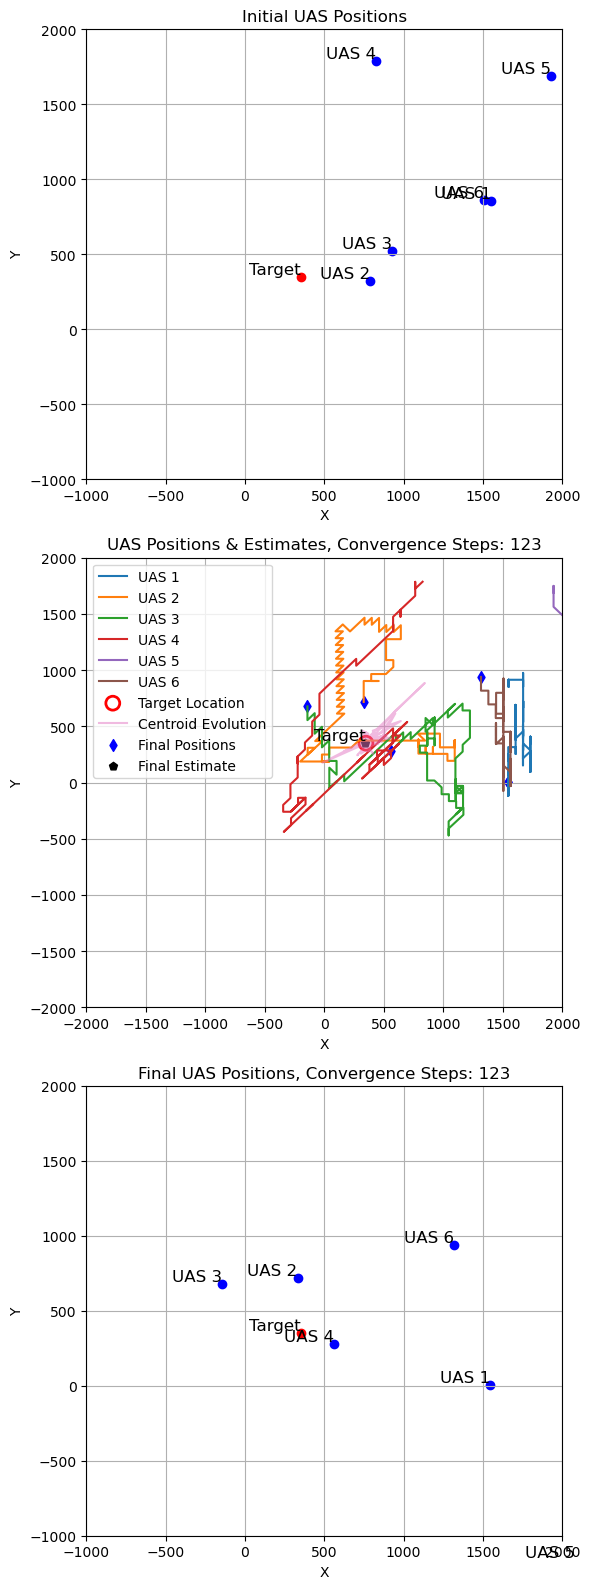

In [65]:
print("Initial Drone-to-Target Distances\n",np.round(env.initial_loc,2))
print("Final Drone Locations\n", env.drones_location)
plot_locations(env.initial_loc, env.drones_location, env.target_location, env.current_step)


In [12]:
#!pip install jinja2

In [21]:
import pandas as pd

results_df = pd.DataFrame({'Num_Steps': ls_numsteps, 'Median_Error': ls_median_err, 'Median_CEP': ls_median_cep,
                           'Median_X': ls_med_x, 'Median_Y': ls_med_y, 'MAD_X': ls_mad_x, 'MAD_Y': ls_mad_y,
                          'Mean_X': ls_mean_x, 'Mean_Y': ls_mean_y, 'Std_X': ls_stddev_x, 'Std_Y': ls_stddev_y,
                          'Distance_Moved': ls_totaldistmoved, 'TotalReward': total_rewards_per_simulation} )

results_df.to_csv('iter2_results10000.csv', index=False)
results_df = pd.read_csv('iter2_results10000.csv')

results_df.describe().style.format("{:.2f}")

,Num_Steps,Median_Error,Median_CEP,Median_X,Median_Y,MAD_X,MAD_Y,Mean_X,Mean_Y,Std_X,Std_Y,Distance_Moved,TotalReward
count,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00
mean,165.41,17.66,6.50,350.79,349.51,4.19,4.36,338.96,346.14,188.77,111.79,12100.01,-1.56
std,192.49,63.29,78.99,46.46,57.77,54.81,56.93,2334.86,910.41,8301.87,2998.90,22363.50,104.12
min,1.00,0.00,0.02,-1171.48,-2950.14,0.01,0.01,-199466.76,-73245.21,0.04,0.05,2885.16,-1300.00
25%,54.00,4.03,0.99,343.70,343.48,0.56,0.55,343.17,342.86,2.66,2.47,6304.95,-26.00
50%,102.00,9.10,1.41,349.98,350.15,0.89,0.88,350.02,350.02,5.45,5.08,7661.82,14.00
75%,194.00,17.97,1.74,356.59,356.77,1.24,1.24,357.35,357.57,13.76,12.58,10663.44,52.00
max,1000.00,3993.79,4381.00,3174.04,2776.50,3664.58,2582.46,116816.90,39598.88,739780.28,216649.97,879449.49,494.00


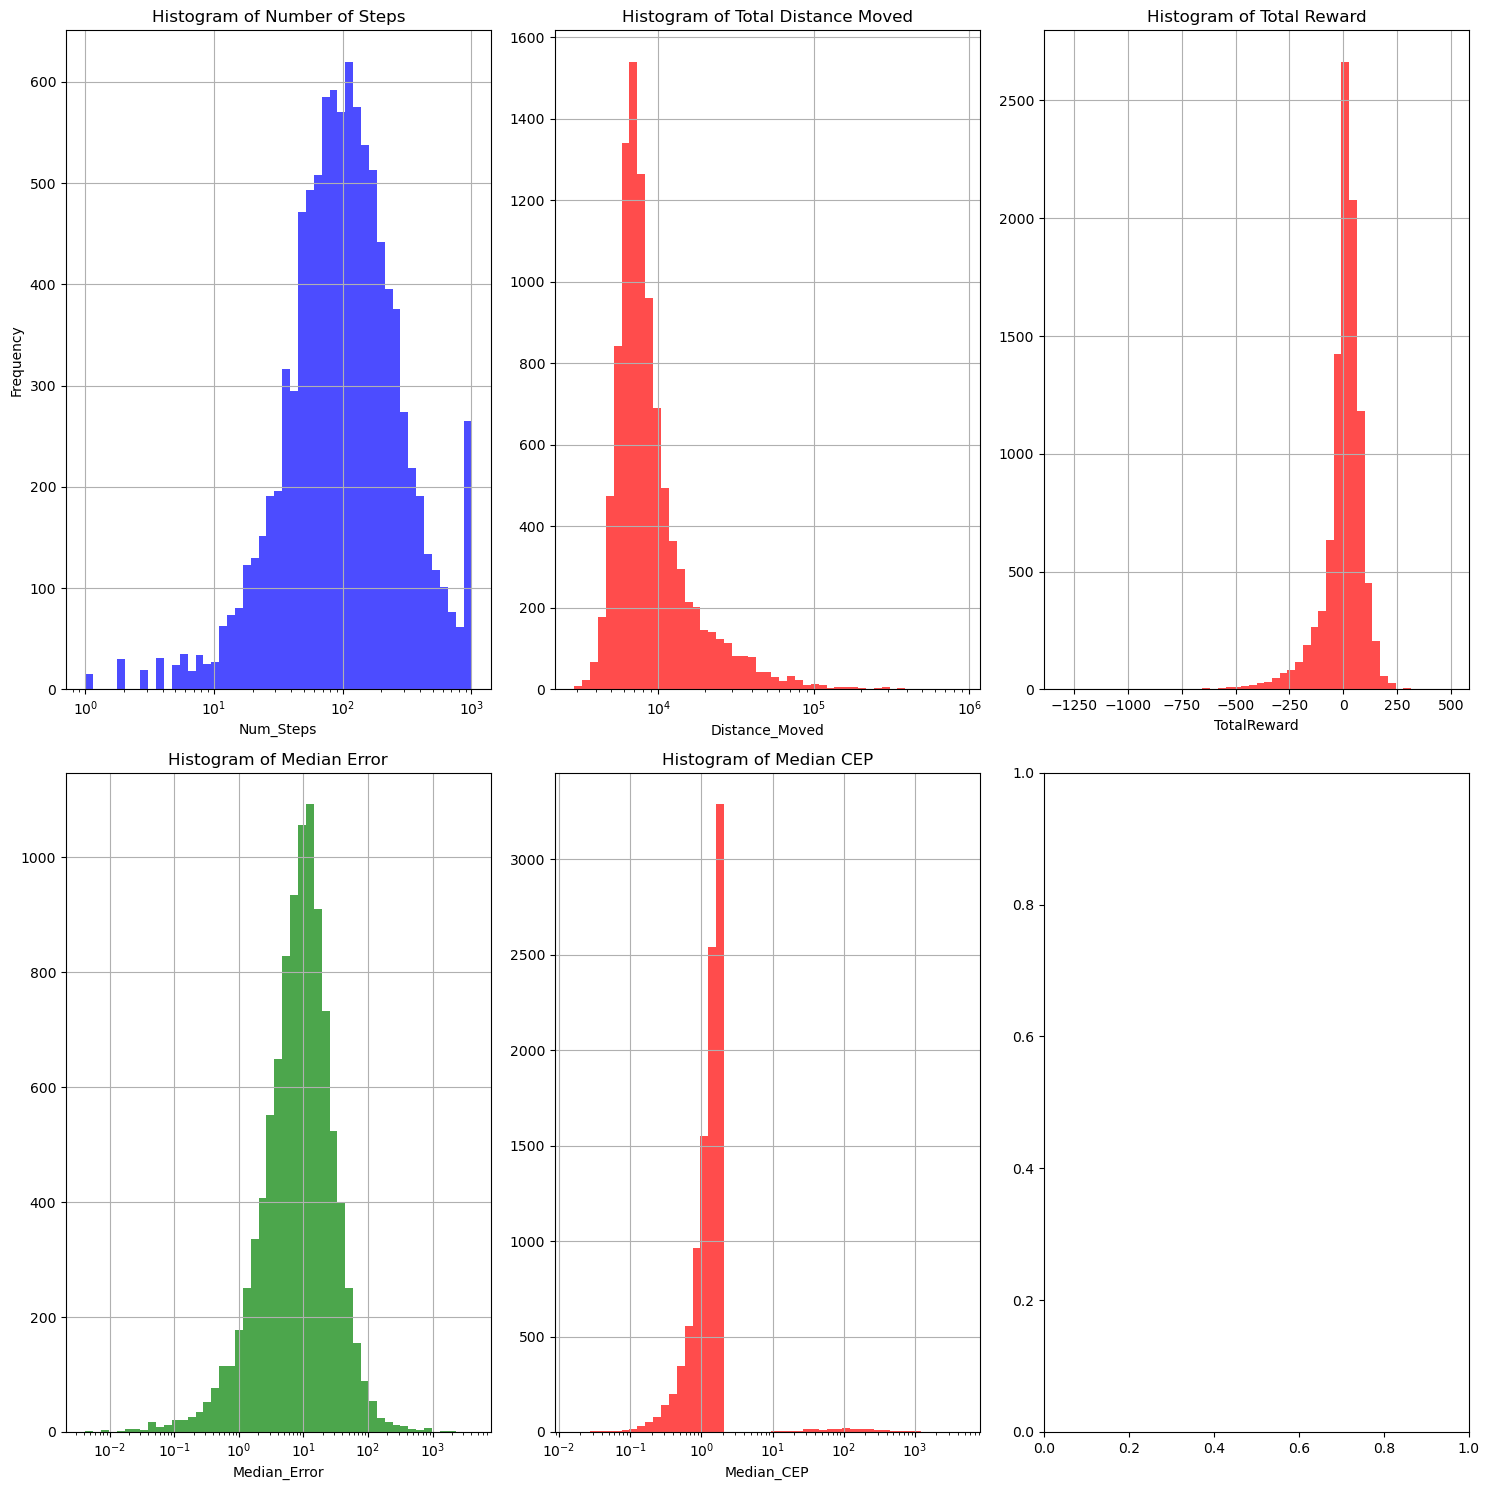

In [22]:
# Create a figure and an array of subplots with 1 row and 3 columns
fig, axes = plt.subplots(2, 3, figsize=(15, 15))
bincount = 50
log_bins = np.logspace(np.log10(results_df['Num_Steps'].min()), np.log10(results_df['Num_Steps'].max()), bincount)


# Plot data
results_df['Num_Steps'].hist(ax=axes[0][0], bins=log_bins, color='blue', alpha=0.7)
axes[0][0].set_title('Histogram of Number of Steps')
axes[0][0].set_xlabel('Num_Steps')
axes[0][0].set_ylabel('Frequency')
axes[0][0].set_xscale('log')

log_bins = np.logspace(np.log10(results_df['Distance_Moved'].min()), np.log10(results_df['Distance_Moved'].max()), bincount)

results_df['Distance_Moved'].hist(ax=axes[0][1], bins=log_bins, color='red', alpha=0.7)
axes[0][1].set_title('Histogram of Total Distance Moved')
axes[0][1].set_xlabel('Distance_Moved')
axes[0][1].set_xscale('log')


results_df['TotalReward'].hist(ax=axes[0][2], bins=bincount, color='red', alpha=0.7)
axes[0][2].set_title('Histogram of Total Reward')
axes[0][2].set_xlabel('TotalReward')

log_bins = np.logspace(np.log10(results_df['Median_Error'].min()), np.log10(results_df['Median_Error'].max()), bincount)


results_df['Median_Error'].hist(ax=axes[1][0], bins=log_bins, color='green', alpha=0.7)
axes[1][0].set_title('Histogram of Median Error')
axes[1][0].set_xlabel('Median_Error')
axes[1][0].set_xscale('log')

log_bins = np.logspace(np.log10(results_df['Median_CEP'].min()), np.log10(results_df['Median_CEP'].max()), bincount)

results_df['Median_CEP'].hist(ax=axes[1][1], bins=log_bins, color='red', alpha=0.7)
axes[1][1].set_title('Histogram of Median CEP')
axes[1][1].set_xlabel('Median_CEP')
axes[1][1].set_xscale('log')


# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

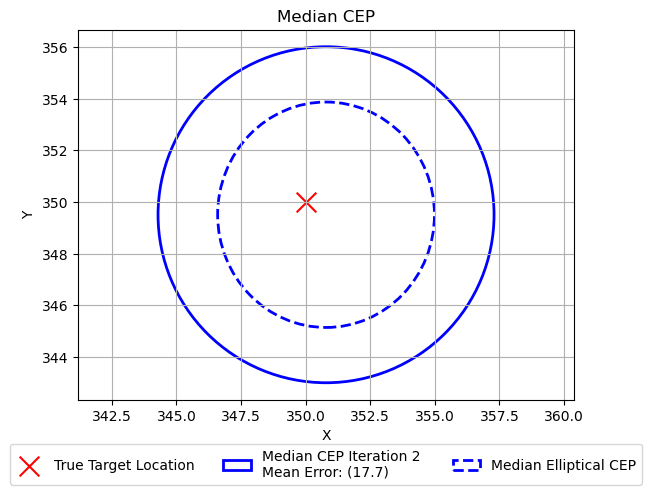

In [23]:
mean_num_steps = results_df['Num_Steps'].mean()
mean_median_error = results_df['Median_Error'].mean()
mean_median_cep = results_df['Median_CEP'].mean()
mean_median_x = results_df['Median_X'].mean()
mean_median_y = results_df['Median_Y'].mean()
mean_mad_x = results_df['MAD_X'].mean()
mean_mad_y = results_df['MAD_Y'].mean()
mean_mean_x = results_df['Mean_X'].mean()
mean_mean_y = results_df['Mean_Y'].mean()
mean_std_x = results_df['Std_X'].mean()
mean_std_y = results_df['Std_Y'].mean()

# Plot Results
plt.scatter(env.target_location[0][0],env.target_location[0][1],color='red', label='True Target Location', marker='x',s=200)

# Plot circle using MAD deviations of x & y values
radius = mean_median_cep
median_cep_legend2 = f'Median CEP Iteration 2 \nMean Error: ({np.round(mean_median_error,1)})'
circle_median = Ellipse((mean_median_x, mean_median_y), 2*radius, 2*radius, edgecolor='blue', facecolor='none', linestyle='-', linewidth=2, label=median_cep_legend2)
plt.gca().add_patch(circle_median)

# Plot ellipse using median absolute distance values
median_cep_legend = f'Median Elliptical CEP'# ({np.round(mean_mad_x, 2)}, {np.round(mean_mad_y, 2)})'
ellipse_median = Ellipse((mean_median_x, mean_median_y), 2*mean_mad_x, 2*mean_mad_y, edgecolor='blue', facecolor='none', linestyle='--', linewidth=2, label=median_cep_legend)
plt.gca().add_patch(ellipse_median)

# Plot circle using std deviations of x & y values
radius = np.sqrt(mean_std_x**2 + mean_std_y**2)
mean_cep_legend = f'$\mu$ CEP ({np.round(radius,2)})'
circle_mean = Ellipse((mean_mean_x, mean_mean_y), 2*radius, 2*radius, edgecolor='green', facecolor='none', linestyle='-', linewidth=2, label=mean_cep_legend)
#plt.gca().add_patch(circle_mean)

# Plot ellipse using standard deviations
std_cep_legend = f'$\sigma$ Elliptical CEP ({np.round(mean_std_x, 2)}, {np.round(mean_std_y, 2)})'
ellipse_std = Ellipse((mean_mean_x, mean_mean_y), 2*mean_std_x, 2*mean_std_y, edgecolor='green', facecolor='none', linestyle='--', linewidth=2, label=std_cep_legend)
#plt.gca().add_patch(ellipse_std)

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Median CEP')
plt.legend(
    loc='lower center', 
    bbox_to_anchor=(0.5, -.25),
    ncol=3, 
)
plt.grid(True)
plt.axis('equal')  # Equal aspect ratio
plt.show()

** STOP HERE THE REST OF THE CODE NEEDS SOME TLC **

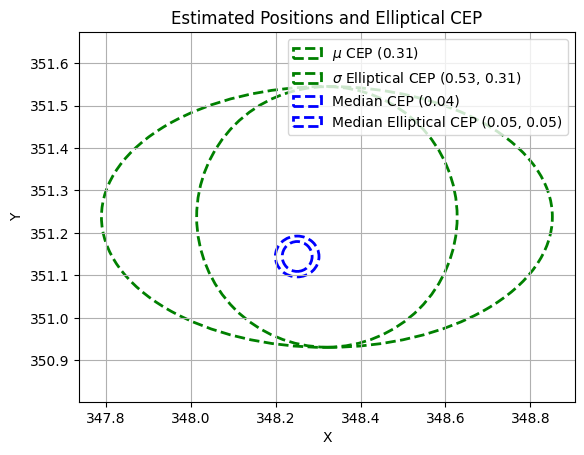

In [538]:
# Assuming LOCASoln is returned from the function call
# LOCASoln is a list of estimated positions (numpy arrays)
estimated_positions = np.array(env.LOCASoln)

# Calculate elliptical CEP
std_x, std_y, mean_x, mean_y, median_x, median_y, mad_x, mad_y = calculate_elliptical_CEP(estimated_positions)
med_err =  np.linalg.norm(np.array(median_x,median_y)-env.target_location,axis = 1)

if DEBUG: print("Standard Deviation (x,y):",  np.round(std_x,2),", ",np.round(std_y,2))
if DEBUG: print("Median Absolute Distance  (x,y):", np.round(mad_x, 2),", ",np.round(mad_y,2))
if DEBUG: print("Mean Target Estimate (x,y):", np.round(mean_x,2),", ",np.round(mean_y,2))
if DEBUG: print("Median Target Estimate (x,y):", np.round(median_x, 2),", ",np.round(median_y,2))
if DEBUG: print("Median Error:", np.round(med_err,2))

# Plotting the results
#plt.figure()
#plt.scatter(estimated_positions[:, 0], estimated_positions[:, 1], label='Estimated Positions')
#plt.scatter(env.target_location[0][0],env.target_location[0][1],color='red', label='True Target Location', marker='x',s=200)

#plt.scatter(mean_x, mean_y, color='green', label='$\mu$ Centroid')
#plt.scatter(median_x, median_y, color='blue', label='Median Centroid')


# Plot circle using std deviations of x & y values
radius = np.sqrt(std_x**2 + std_y**2) / 2
mean_cep_legend = f'$\mu$ CEP ({np.round(radius,2)})'
circle_mean = Ellipse((mean_x, mean_y), 2*radius, 2*radius, edgecolor='green', facecolor='none', linestyle='--', linewidth=2, label=mean_cep_legend)
plt.gca().add_patch(circle_mean)

# Plot ellipse using standard deviations
std_cep_legend = f'$\sigma$ Elliptical CEP ({np.round(std_x, 2)}, {np.round(std_y, 2)})'
ellipse_std = Ellipse((mean_x, mean_y), 2*std_x, 2*std_y, edgecolor='green', facecolor='none', linestyle='--', linewidth=2, label=std_cep_legend)
plt.gca().add_patch(ellipse_std)

# Plot circle using MAD deviations of x & y values
radius = np.sqrt(mad_x**2 + mad_y**2) / 2
median_cep_legend = f'Median CEP ({np.round(radius,2)})'
circle_median = Ellipse((median_x, median_y), 2*radius, 2*radius, edgecolor='blue', facecolor='none', linestyle='--', linewidth=2, label=median_cep_legend)
plt.gca().add_patch(circle_median)

# Plot ellipse using median absolute distance values
median_cep_legend = f'Median Elliptical CEP ({np.round(mad_x, 2)}, {np.round(mad_y, 2)})'
ellipse_median = Ellipse((median_x, median_y), 2*mad_x, 2*mad_y, edgecolor='blue', facecolor='none', linestyle='--', linewidth=2, label=median_cep_legend)
plt.gca().add_patch(ellipse_median)



plt.xlabel('X')
plt.ylabel('Y')
plt.title('Estimated Positions and Elliptical CEP')
plt.legend()
plt.grid(True)
plt.axis('equal')  # Equal aspect ratio
plt.show()

-------------------

## Motivation

In recent years, unmanned autonomous vehicles and systems (UAVs, UAS) have become more abundant and their missions have drastically increased in scope. These systems can be small and versatile, allowing the ability to reach locations that manned systems are unable to access, such as hostile locations, underground tunnels, and confined spaces within a building. Emitter-locating UAS have been studied and developed for applications such as search and rescue missions, where it is required to obtain the geolocation estimate of an emergency transponder beacon whose location was previously unknown. Because of scenarios like this, it is highly desirable to obtain an estimate of a sensed emitter’s location that is accurate and requires as few measurements and computations as possible. This is particularly true when the emitter of interest is transmitting signals of very short time duration.

It is well-known that an array’s collective Field of View (FOV) with respect to a transmitter location greatly affects emitter location estimates, particularly for time-based emitter location algorithms that are sensitive to the relative geometry of the sensor array and its orientation to the emitter. Therefore, the agility and adaptability of a UAS network configured as a cooperative wireless sensor array is desirable, since it can be enabled to dynamically reconfigure its array geometry such that iterative measurements cause the emitter location estimate to converge to the true emitter location more quickly and with fewer measurements. Further, in an environment such as a dense urban area, buildings and other vehicles become scatterers to RF signals and lead to measurement errors, and a UAS has versatility over stationary sensors because they have the ability to maneuver to avoid physical structures that block signals and lead to measurement errors. 

We are motivated to utilize a cooperative unmanned aerial system that operates as a sensor array to locate an emitter with an unknown location. For this system, we assume that the sensors are wirelessly connected with a a wireless ad hoc network (WANET), they have the ability to self-localize to a high level of accuracy using an on-board LIDAR system, they have a highly accurate on-board timing source and reference that is synchronized prior to the mission, and we assume the system can accurately correlate signals that are received. With these capabilities, the use of a time difference of arrival (TDOA) measurement of the emitter signal at each sensor can be implemented to localize the emitter. A similar system was studied in [1], where the hardware limitations were analyzed to find a lower accuracy bound. 

To leverage the maneuverability of this system, we analyze in this work how the change in array geometry can lead to improved accuracy in emitter localization. The use of reinforcement learning in this scenario can evaluate iterative geometry updates and localization error and reward states that lead to improved accuracy, thus determining an optimal geometry for the system. Reinforcement approaches have been applied to robotic path planning [2] and specifically Q-learning has been used for UAS in emitter location scenarios in single agent [3] and multi-agent [4] approaches. In many methods, the system relies on increasing received signal strength (RSS) from the emitter at each sensor to quantify the reward in geometry state updates. We hypothesize that the utilization of a TDOA localization algorithm in a multi-agent Q-learning provides a reward metric that enables the cooperative use of sensor array and leads to a geometry that provides a highly accurate emitter localization. To this end, we will show the comparison in reinforcement learning convergence using both RSS and TDOA localization.

## Related Work 

Previous approaches have considered Reinforcement Learning, specifically Q-Learning, to search for the highest received signal strength (RSS) and reward states that move the Drones closer to the highest RSS. 

In paper [3] the approach taken was to use directional antennas used in conjunction with directional-aware Q-learning for localization. This was compared with two baseline tests. The first baseline test used an omnidirectional antenna and Q-learning was used to measure the RSS values. The second baseline used a directional antenna on a UAV, with no reference to Q-learning, where the device moved in the direction that received the highest RSS value.  The modified Q-learning approach with a directional antenna outperformed Q-learning with an omnidirectional antenna and the maximum RSS method with a directional antenna. 

By utilizing a multi-agent Q-learning (reinforcement learning) approach as demonstrated in [4], we can study the effect of rewarding drones within shared state and action spaces. In a MQL (Multi-Agent Q-learning) algorithm, "each UAV takes account of other UAVs' flight decisions with the objective of promoting cooperative actions in order to achieve the highest reward" [4]. MQL algorithms behave similarly to SQL (Single-Agent Q-learning) algorithms in that each agent iteratively interacts with the environment to determine the optimal policy for achieving the maximal long-term reward. Using "exchanged rewards" broadcasted by each agent during specific actions, the MQL value function is updated to reflect the overall success of the system.

Because we intend to utilize a localiztion approach in addition to RSS, we consider an algorithm developed by Ralph Schmidt [5] called "Location on a Conic Axis" (LOCA). This algorithm differentiates itself from the geometry of traditional hyperbolic ranging approaches in that it considers the sensors to be on the perimeter of a conic and the emitter to be at the focus of the conic, which is contained on the conic axis. In a two dimensional geometry, three sensors are needed to find the focus. If more sensors are used, the algorithm can be used with any combination of a subset of three sensors and leads to as many emitter location estimates (for example, using 5 sensors leads to $\binom{5}{3} = 10$ results). With this approach, since the algorithm finds the emitter on the straight-line conic axis and with conics there may be two foci, to resole the focus ambiguity each resulting conic axis can be analyzed together as a system of intersecting linear equations so that their intersection is the focus. The advantage of this method provides a computationally efficient approach to TDOA processing.

In [1], a similar system was studied with the LOCA algorithm that utilized on-board sensor positioning and timing references. There, the UAS sensor positioning accuracy was bounded to 2 cm, and the use of commercial chip scale atomic clocks bounded the timing reference to as low as 1 ns. However, while feasible with this hardware, practically 1 ns is very difficult to achieve, therefore we analyze a 10 ns timing accuracy. 

In [6], the system in [1] was further studied to quantify the impacts of environmental errors to emitter localization. In that study, the use of urban propagation models such as ITU-R 1411-12 [7] are utilized to formulate stochastic models of a dense urban environment. It was found that for this system, with eight or more sensors, an urban environment has similar error as that of a system with 10 ns local timing inaccuracy. Since both errors are dependent on the signal propagation distance, we consider the errors as additive, so that for an urban environment we can analyze this error as a 10 ns timing inaccuracy.

## Methods

The following methods aim to refine the localization and tracking capabilities of a drone system by iteratively improving its accuracy and efficiency in determining the position of a target emitter. Here's how we will group the methods into iterations for comparison:

*Iteration 1*

In the first iteration, the system uses Q-Learning



$$
Q(s, a) \leftarrow Q(s, a) + \alpha \left[ r + \gamma \max_{a'} Q(s', a') - Q(s, a) \right]
$$

where:

* $s$ is the current state.
* $a$ is the action taken.
* $r$ is the reward received.
* $s′$ is the new state after action a is taken.
* $α$ is the learning rate (how much new information overrides old information).
* $γ$ is the discount factor (importance of future rewards).

For each state, the system can make 9-directional movements and is rewarded from increased RSS (which enhances the initial 5-directional strategy shown in this draft by incorporating additional movement options—up, down, left, right, and diagonally—to better hone in on the signal source). 

The RSS is found by the Friis free space equation:
$$
\text{RSS}_{\text{i}} (dBm) = -20 \times \log_{10} \left(\frac{{4 \pi \times R_i f}}{{c}}\right) + \text{P}_{\text{e}}
$$
where:
* $R_i$ is the distance from the emitter to the sensor in m
* $f$ is the emitter operational frequency in Hz, which is 5 GHz
* $c$ is the signal propagation speed, which is $3\times 10^8$ m/s in a vacuum
* $P_e$ is the emitter output power in dBm

*Iteration 2*

The second iteration shifts focus to $N$-directional movements informed by the LOCA algorithm, where drones move towards the estimated position of the emitter. The estimated position is found by an average of the LOCA output, called the centroid, where subsets of sensors provide individual estimates with LOCA and the target's position is approximated by averaging these estimates. We determine the direction of movement using the current position of the sensor and the estimated target position. This iteration still employs the reward mechanism based on increased RSS but integrates more precise directional guidance from LOCA data. 

*Iteration 3*

In the third iteration, the strategy evolves to minimize the variance from the mean localization solution. In this way, we determine a circular error probable (CEP) radius, which is a measure of the error in a target localization when using multiple estimates, using the standard deviation of Euclidean distances for each LOCA estimate from the centroid. The goal in this iteration is effectively to reduce the error ellipse's radius, and this method is anticipated to achieve the smallest error radius or converge to it more rapidly by focusing on a 95% confidence region around the centroid. In this iteration, each step does not require the drones to necessarily move closer to the emitter, the only requirement is that the CEP radius is reduced. Since the drones will not be strictly moving in the direction of the estimated location of the emitter, we will implement reinforcement learning techniques in this iteration to determine their movements.

*Iteration 4 - optional*

An optional fourth iteration, contingent on time constraints, combines elements from the first and third iterations. It seeks to minimize the error ellipse radius while maximizing RSS, using a weighted approach to balance both factors.

*Success Metric*

The success of each iteration is measured by the decreasing radius of the error ellipse and the reduction in the Euclidean distance between the center of this ellipse and the true target position. The system iterates until it reaches a predefined number of steps, a time limit, or the emitter is within a specified radius, indicating successful localization. We keep this metric the same across all iterations in order to maintain a fair comparison of success.

Additionally, the system's robustness and accuracy will be tested through Monte Carlo simulations with a series of initial positions to validate the localization estimates against the true target location. Each iteration will be conducted in 2 dimensional environments, where mostly zero-mean Gaussian-distributed error is added to the TOA, $\epsilon_t$ with $\sigma^2 = 10 ns$, to the individual sensor positions, with $\epsilon_x, \epsilon_y, \epsilon_z$ having $\sigma^2 = 2 cm$, including additional time delay due to multipath, with $\epsilon_n$ as $\sigma^2 = 10 ns$, and including a corresponding RSS noise value for multipath & signal fading, $\epsilon_p$ as $\mu = 3 dB$ and $\sigma^2 = 5 dB$. 

## Results and Conclusion

In our first run of the Q-Learning method, we begin with the drones in random initial locations and simulate the RSS for each location. We also simulate a TOA of the signal at each drone so that we can estimate the position of the target using the LOCA algorithm. The initial positions are shown in the first figure. At each state, we observe the RSS and move in one of 5 directions. If the movement results in an increased RSS, the state receives a positive reward, and if it results in a decreased RSS, the state receives a negative reward. This continues until we achieve a "maximum" RSS value for all the drones that corresponds to a distance of at least 60m from the target. Each step is depicted in the second figure, where each drone trajectory is plotted. At the final state, which is depicted in the third figure, the target position is again estimated using the LOCA algorithm.

In the below tables, we see the RSS values and distances from the drones to the target corresponding to the initial positions, and we see the RSS values and distances from the drones to the target corresponding to the final positions. In all cases, the RSS values increase while the distances decrease. In the following table we show the actual target location, the initial (mean) LOCA estimate, the final (mean) LOCA estimate, and the error for each estimate which is the Euclidean distance between the estimated target location and true target location. Interestingly, the estimate for the initial position is a better estimate than the result for the final position. Therefore, with this system of drones with omnidirectional antennas, increased RSS alone may not be enough to reduce the localization error.

In the final version of this study, we will repeat this test using 9 directions (instead of 5) and plan to evaluate the remaining iterations discussed in the previous section.

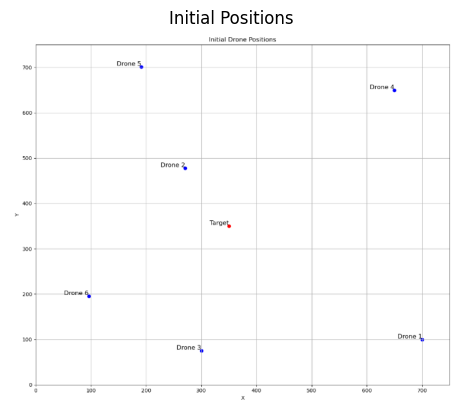

In [539]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Display the image
plt.imshow(mpimg.imread("draft_1initialpos.png"))
plt.title('Initial Positions')
plt.axis('off')  # Turn off axis
plt.show()

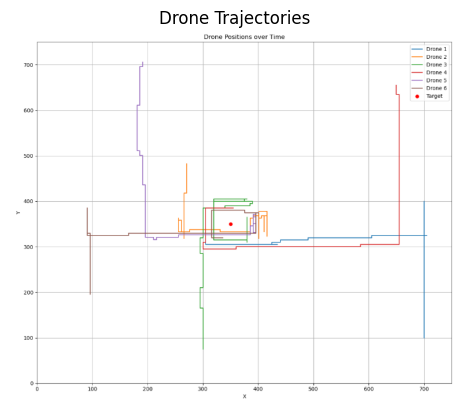

In [540]:
# Display the image
plt.imshow(mpimg.imread("draft_2movements.png"))
plt.title('Drone Trajectories')
plt.axis('off')  # Turn off axis
plt.show()

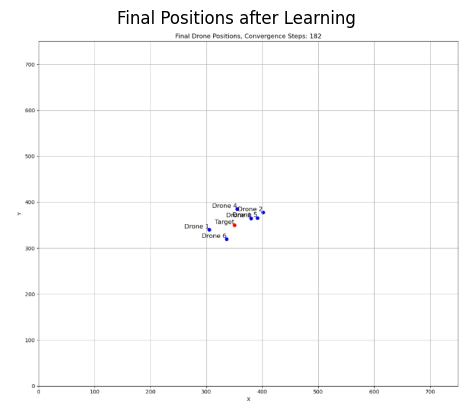

In [541]:
# Display the image
plt.imshow(mpimg.imread("draft_3finalpos.png"))
plt.title('Final Positions after Learning')
plt.axis('off')  # Turn off axis
plt.show()

### RSS Improvement

| Drone | Initial Dist. (m) | Final Dist. (m) | Initial RSS (dBm) | Final RSS (dBm) | RSS Change (dB) |
|------:|-------------------|-----------------|-------------------|-----------------|-----------------|
|   1   |      430.1        |        46.1     |    -89.09         |   -69.69        |    +19.4        |
|   2   |      150.4        |        58.2     |    -79.97         |   -71.72        |    + 8.25       |
|   3   |      279.5        |        33.5     |    -85.35         |   -66.93        |    +18.42       |
|   4   |      424.3        |        33.4     |    -88.97         |   -67.39        |    +21.58       |
|   5   |      385.3        |        44.0     |    -88.14         |   -69.29        |    +18.85       |
|   6   |      297.6        |        33.1     |    -85.89         |   -66.82        |    +19.07       |

### Target Information
| Target Info |  Location or Error (m)  | 
|------------------|--------------|
| Actual Location (x,y)  | (350, 350) |
| Initial Estimate (x,y)| (349.3,  349.9) |
| Initial Error (m)| 0.71        | 
| Final Estimate  (x,y) | (350.2, 353.3)|
| Final Error (m)  | 3.31        |

## References
[1] C. Peters and M. A. Thornton, "Cooperative UAS Geolocation of Emitters with Multi-Sensor-Bounded Timing and Localization Error," 2023 IEEE Aerospace Conference, Big Sky, MT, USA, 2023, pp. 1-13, doi: 10.1109/AERO55745.2023.10116023.

[2] J. Jyoti and R. S. Batth, "Unmanned Aerial vehicles (UAV) Path Planning Approaches," 2021 International Conference on Computing Sciences (ICCS), Phagwara, India, 2021, pp. 76-82, doi: 10.1109/ICCS54944.2021.00023.

[3] S. Wu, "Illegal radio station localization with UAV-based Q-learning," in China Communications, vol. 15, no. 12, pp. 122-131, Dec. 2018, doi: 10.12676/j.cc.2018.12.010. 

[4] Y. -J. Chen, D. -K. Chang and C. Zhang, "Autonomous Tracking Using a Swarm of UAVs: A Constrained Multi-Agent Reinforcement Learning Approach," in IEEE Transactions on Vehicular Technology, vol. 69, no. 11, pp. 13702-13717, Nov. 2020, doi: 10.1109/TVT.2020.3023733.

[5] R. O. Schmidt, "A New Approach to Geometry of Range Difference Location," in IEEE Transactions on Aerospace and Electronic Systems, vol. AES-8, no. 6, pp. 821-835, Nov. 1972, doi: 10.1109/TAES.1972.309614.

[6] C. Peters and M. A. Thornton, "Localization Error Mitigation through Dynamic Repositioning in Cooperative UAS Arrays," 2024, submitted as publication.

[7] Radiocommunication Sector of International Telecommunication Union, "Propagation data and prediction methods for the planning of short-range outdoor radiocommunication systems and radio local area networks in the frequency range 300 MHz to 100 GHz", Rec. ITU-R P. 1411–12 ITU Recommendation, Aug. 2023.